# Data Science & LLM Technical Assessment

## Assignment Overview

This notebook:
- Builds predictive models for 30-day hospital readmission
- Extracts clinical entities from discharge notes using NLP/LLMs
- Summarizes methods and findings

## 1. Imports & Data Loading

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load the data
df = pd.read_csv("Assignment_Data.csv")
df.head()

,patient_id,age,gender,diagnosis_code,num_previous_admissions,medication_type,length_of_stay,readmitted_30_days,discharge_note
0,1,71,Male,D002,3,Type C,2,0,Good recovery trajectory. Follow-up scan sched...
1,2,34,Female,D002,1,Type B,3,1,Stable post-surgery. Advised to avoid physical...
2,3,80,Male,D002,2,Type C,5,1,Symptoms controlled. Monitoring for relapse ad...
3,4,40,Female,D002,2,Type C,11,0,Stable post-surgery. Advised to avoid physical...
4,5,43,Female,D001,1,Type C,8,1,Stable post-surgery. Advised to avoid physical...


#### Dataset Dictionary

| Column Name              | Description                                     |
|--------------------------|-------------------------------------------------|
| patient_id               | Unique patient identifier                       |
| age                      | Age of the patient                              |
| gender                   | Gender of the patient (Male/Female)             |
| diagnosis_code           | Coded diagnosis                                 |
| num_previous_admissions  | Number of previous admissions                   |
| medication_type          | Medication type prescribed                      |
| length_of_stay           | Length of hospital stay (days)                  |
| readmitted_30_days       | Target variable: 1=Readmitted, 0=Not readmitted |
| discharge_note           | Free-text hospital discharge summary            |

**Target:**  
- `readmitted_30_days`: **1** if patient was readmitted within 30 days, **0** otherwise.

## 2. Data Inspection & Exploratory Analysis

In [5]:
# Info about the dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   patient_id               200 non-null    int64 
 1   age                      200 non-null    int64 
 2   gender                   200 non-null    object
 3   diagnosis_code           200 non-null    object
 4   num_previous_admissions  200 non-null    int64 
 5   medication_type          200 non-null    object
 6   length_of_stay           200 non-null    int64 
 7   readmitted_30_days       200 non-null    int64 
 8   discharge_note           200 non-null    object
dtypes: int64(5), object(4)
memory usage: 14.2+ KB
None


In [6]:
print(df.describe())

       patient_id         age  num_previous_admissions  length_of_stay  \
count  200.000000  200.000000               200.000000      200.000000   
mean   100.500000   53.720000                 1.600000        7.865000   
std     57.879185   21.294574                 1.310951        4.134276   
min      1.000000   20.000000                 0.000000        1.000000   
25%     50.750000   34.000000                 1.000000        4.000000   
50%    100.500000   54.000000                 1.000000        8.000000   
75%    150.250000   73.000000                 2.000000       11.000000   
max    200.000000   89.000000                 6.000000       14.000000   

       readmitted_30_days  
count           200.00000  
mean              0.32500  
std               0.46955  
min               0.00000  
25%               0.00000  
50%               0.00000  
75%               1.00000  
max               1.00000  


In [7]:
# Check for missing values
print("Missing values:\n", df.isnull().sum())

Missing values:
 patient_id                 0
age                        0
gender                     0
diagnosis_code             0
num_previous_admissions    0
medication_type            0
length_of_stay             0
readmitted_30_days         0
discharge_note             0
dtype: int64


- There is no missing value.

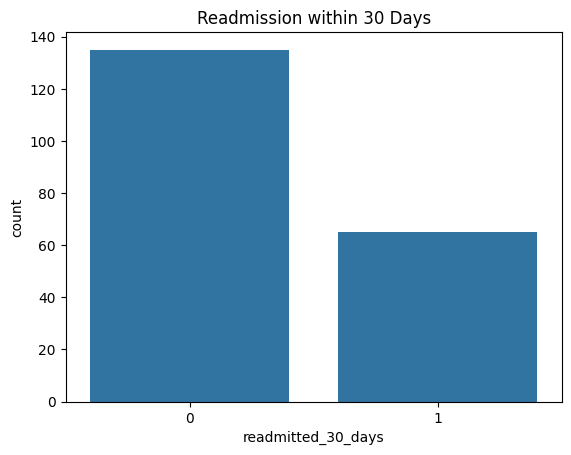

readmitted_30_days
0    0.675
1    0.325
Name: proportion, dtype: float64


In [8]:
# Class balance
sns.countplot(x="readmitted_30_days", data=df)
plt.title("Readmission within 30 Days")
plt.show()
print(df["readmitted_30_days"].value_counts(normalize=True))

- About 67% of patients were **not** readmitted within 30 days; 33% were.
- The dataset has a mild class imbalance.

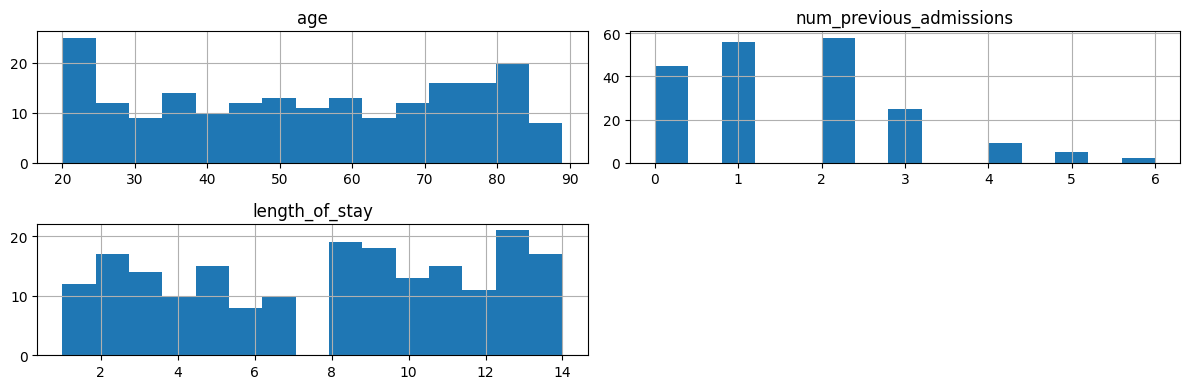

In [9]:
# Numeric feature distributions
numeric_cols = ["age", "num_previous_admissions", "length_of_stay"]
df[numeric_cols].hist(bins=15, figsize=(12, 4))
plt.tight_layout()
plt.show()

- Age is spread from ~20 to almost 90, with peaks in the 30s and 70s.
- Most patients have 0–2 previous admissions.
- Hospital stays typically last 4–8 days.

In [10]:
# Categorical value counts
for col in ["gender", "diagnosis_code", "medication_type"]:
    print(f"\n{col} value counts:\n", df[col].value_counts())


gender value counts:
 gender
Female    107
Male       93
Name: count, dtype: int64

diagnosis_code value counts:
 diagnosis_code
D001    56
D002    54
D004    53
D003    37
Name: count, dtype: int64

medication_type value counts:
 medication_type
Type B    69
Type A    67
Type C    64
Name: count, dtype: int64


- Gender is roughly balanced.
- Diagnosis codes and medication types are fairly evenly distributed.

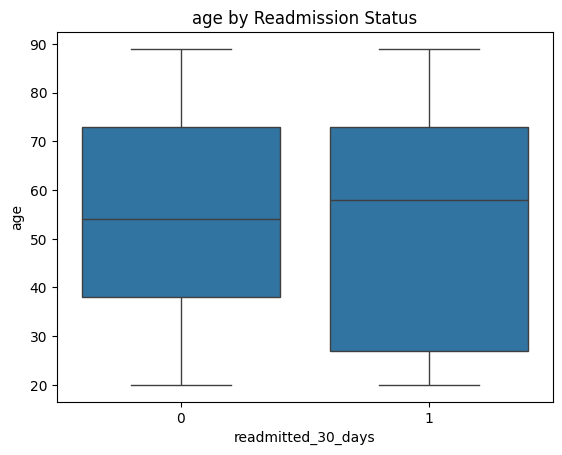

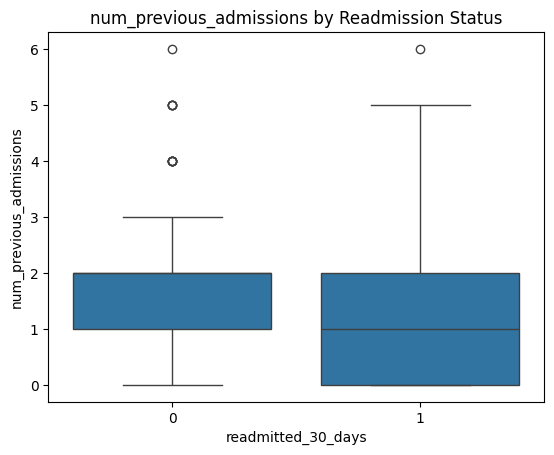

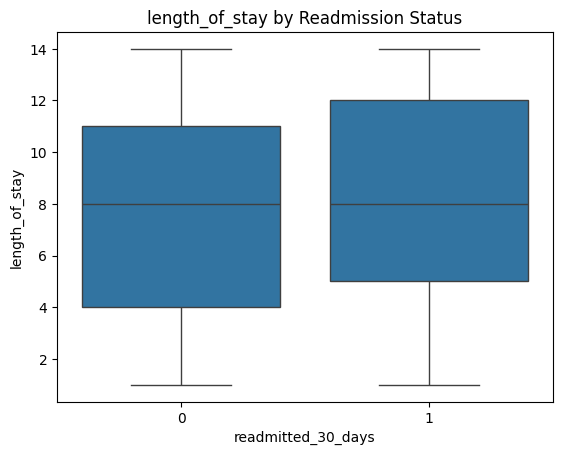

In [11]:
# Boxplots by target
for col in numeric_cols:
    plt.figure()
    sns.boxplot(x="readmitted_30_days", y=col, data=df)
    plt.title(f"{col} by Readmission Status")
    plt.show()

- Patients who are readmitted tend to be slightly older, have longer stays, and more previous admissions.
- Differences are visible but not dramatic.

## 3. Feature Engineering & Data Preparation

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

- Label encoding is used for categorical variables because tree-based models (Random Forest) are not sensitive to monotonicity of labels. For linear models, one-hot encoding could also be considered.

In [13]:
# Drop patient_id and discharge_note for modeling
df_model = df.drop(columns=["patient_id", "discharge_note"])

In [14]:
# Encode categoricals
categoricals = ["gender", "diagnosis_code", "medication_type"]
le_dict = {}
for col in categoricals:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col])
    le_dict[col] = le

In [15]:
# Features and target
X = df_model.drop(columns=["readmitted_30_days"])
y = df_model["readmitted_30_days"]

In [16]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

In [17]:
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Class balance in train:", y_train.value_counts(normalize=True))

Train shape: (150, 6) Test shape: (50, 6)
Class balance in train: readmitted_30_days
0    0.673333
1    0.326667
Name: proportion, dtype: float64


**Handling Class Imbalance:**  
- The target class is somewhat imbalanced. In a production scenario, you might use oversampling (e.g. SMOTE) or class weighting. Here, stratified splitting preserves the ratio in train/test.

**Feature Engineering:**  
- No new features were derived for this baseline. Future improvements could engineer features from text or interactions between variables.


## 4. Model Training & Evaluation

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, classification_report, RocCurveDisplay

In [19]:
# Logistic Regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred_lr = logreg.predict(X_test)
y_proba_lr = logreg.predict_proba(X_test)[:, 1]

In [20]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

In [21]:
def eval_metrics(y_test, y_pred, y_proba, model_name="Model"):
    print(f"\n=== {model_name} ===")
    print("ROC AUC:", roc_auc_score(y_test, y_proba))
    print("F1-score:", f1_score(y_test, y_pred))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    RocCurveDisplay.from_predictions(y_test, y_proba)
    plt.title(f"ROC Curve: {model_name}")
    plt.show()


=== Logistic Regression ===
ROC AUC: 0.4283088235294118
F1-score: 0.15384615384615385
Confusion matrix:
 [[26  8]
 [14  2]]
              precision    recall  f1-score   support

           0       0.65      0.76      0.70        34
           1       0.20      0.12      0.15        16

    accuracy                           0.56        50
   macro avg       0.43      0.44      0.43        50
weighted avg       0.51      0.56      0.53        50



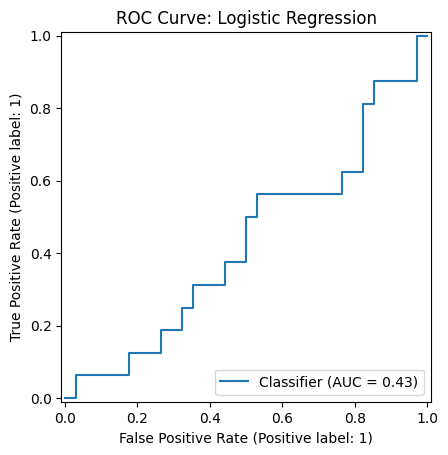


=== Random Forest ===
ROC AUC: 0.4917279411764706
F1-score: 0.35714285714285715
Confusion matrix:
 [[27  7]
 [11  5]]
              precision    recall  f1-score   support

           0       0.71      0.79      0.75        34
           1       0.42      0.31      0.36        16

    accuracy                           0.64        50
   macro avg       0.56      0.55      0.55        50
weighted avg       0.62      0.64      0.62        50



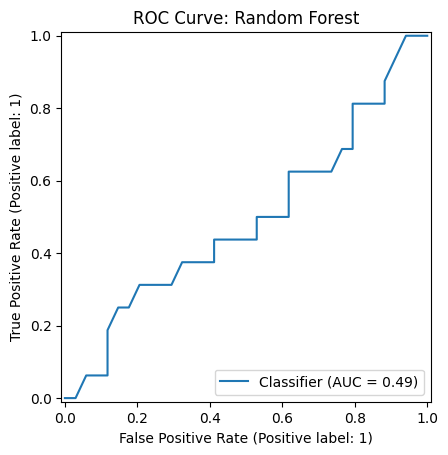

In [22]:
eval_metrics(y_test, y_pred_lr, y_proba_lr, "Logistic Regression")
eval_metrics(y_test, y_pred_rf, y_proba_rf, "Random Forest")

In [23]:
# Feature importances (Random Forest)
importances = rf.feature_importances_
feat_names = X_train.columns
imp_df = pd.DataFrame({'feature': feat_names, 'importance': importances}).sort_values('importance', ascending=False)
print(imp_df)

                   feature  importance
0                      age    0.356918
5           length_of_stay    0.219247
3  num_previous_admissions    0.155831
2           diagnosis_code    0.129426
4          medication_type    0.083601
1                   gender    0.054977


**Model Evaluation:**  
- Random Forest performed slightly better than Logistic Regression, but both models had limited ability to recall readmitted patients (low recall/F1 for class 1).
- ROC AUC values below 0.6 suggest limited predictive signal in the available features.
- In a real clinical setting, higher recall for readmitted patients would be essential.

**Feature Importance:**  
- The most important predictors were: **age**, **length of stay**, and **number of previous admissions**.
- Diagnosis and medication type contributed less.

**Limitations:**  
- Small dataset and few features restrict predictive performance.
- More detailed patient history, lab values, or features derived from discharge notes could improve the model.
- No hyperparameter tuning was performed here (for simplicity).


## 5. Named Entity Recognition (NER) on Discharge Notes

### 5.1 Using SpaCy

In [24]:
import spacy

# Load SpaCy English model (general-purpose)
nlp = spacy.load("en_core_web_sm")

- The general-purpose SpaCy model recognizes basic entities (dates, organizations, etc.), but often misses clinical entities (diagnoses, symptoms, medications).

# Show NER output for first 5 discharge notes
for i, note in enumerate(df["discharge_note"].head()):
    print(f"\nNote {i+1}: {note}")
    doc = nlp(note)
    print("Entities:", [(ent.text, ent.label_) for ent in doc.ents])

### 5.2 Using HuggingFace Transformers (Clinical NER)

In [27]:
from transformers import pipeline

# Note: This may require >2GB RAM and internet for model download
ner = pipeline("ner", model="d4data/biomedical-ner-all", aggregation_strategy="simple")

Device set to use mps:0


- The transformer-based model (`d4data/biomedical-ner-all`) captures more clinical concepts such as DRUG, PROCEDURE, or DISEASE.
- These models are more suitable for healthcare notes, but still may not be perfect.

In [29]:
# Run NER for first 5 notes
for i, note in enumerate(df["discharge_note"].head(5)):
    print(f"\nNote {i+1}: {note}")
    entities = ner(note)
    for ent in entities:
        print(f"  - {ent['word']} ({ent['entity_group']})")


Note 1: Good recovery trajectory. Follow-up scan scheduled next month.

Note 2: Stable post-surgery. Advised to avoid physical exertion.
  - stable (Lab_value)

Note 3: Symptoms controlled. Monitoring for relapse advised.
  - symptoms (Sign_symptom)
  - re (Therapeutic_procedure)
  - ##lapse (Therapeutic_procedure)

Note 4: Stable post-surgery. Advised to avoid physical exertion.
  - stable (Lab_value)

Note 5: Stable post-surgery. Advised to avoid physical exertion.
  - stable (Lab_value)


**Risks and Limitations in Clinical NLP:**
- *Hallucination*: LLMs may invent entities not present in the text.
- *Entity Ambiguity*: Some medical concepts can be misclassified or missed entirely, especially by general models.
- *Coverage*: Clinical NER models (e.g., medSpaCy, biomedical-ner) are better for healthcare texts, but still imperfect.
- *Data Privacy*: Patient notes should be de-identified before using any cloud-based NLP tools.

## Final Report

**Approach:**  
- Performed EDA and feature engineering on structured hospital data.
- Built and evaluated two models (Logistic Regression, Random Forest) to predict 30-day readmission.
- Applied both generic (SpaCy) and domain-specific (Transformers) NER models to extract key medical entities from discharge notes.

**Key Results:**  
- Models achieved modest accuracy (Random Forest ROC AUC ≈ 0.5, F1 ≈ 0.35 for positives).
- Most predictive features: age, length of stay, number of previous admissions.
- Domain-specific NER models extract diagnoses, drugs, and procedures from notes, but results are not perfect.

**Practical Implications:**  
- Predicting readmission with limited features is difficult. More data and text-derived features would help.
- Automated entity extraction can help structure discharge summaries, but requires careful validation.

**Next Steps (if more time/data):**  
- Engineer features from discharge notes (e.g., symptom or treatment counts).
- Tune models and try advanced methods (ensembles, XGBoost, calibration).
- Fine-tune or use clinical LLMs for more reliable information extraction.